In [1030]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [1031]:
import sys
import importlib
from pathlib import Path
sys.path.append(str(Path('../').resolve()))

In [1032]:
from scripts import load_data, geo_data, map
importlib.reload(load_data)
importlib.reload(geo_data)
importlib.reload(map)

<module 'scripts.map' from '/Users/johanslettengren/Desktop/Curamando/grad-recruitment-case-ds-25/scripts/map.py'>

In [1033]:
DATACOLS = ['beftotalt', 'kvinna', 'man', 'ald0_5', 'ald5_10',
       'ald10_15', 'ald15_20', 'ald20_25', 'ald25_30', 'ald30_35', 'ald35_40',
       'ald40_45', 'ald45_50', 'ald50_55', 'ald55_60', 'ald60_65', 'ald65_70',
       'ald70_75', 'ald75_80', 'ald80_85', 'ald85_90', 'ald90_95', 'ald95_100',
       'ald100w']

In [1034]:
from scripts import load_data
importlib.reload(load_data)
df = load_data.load()

# IDs with missing years 16834
# NaNs in final df 0


In [1221]:
from scripts import geo_data
importlib.reload(geo_data)
gdf = geo_data.geo(df)

TypeError: Expected bytes or string, got MultiPolygon

In [1222]:
from scripts import map
importlib.reload(map)
map.plot_map(gdf, 'beftotalt', log=True, highlight=True)

In [1209]:
from scripts import filter
importlib.reload(filter)
filtered = filter.apply_filter(gdf)

In [ ]:
ind = filtered.groupby('block_id')['block_id'].nunique().rename('ind').reset_index() 
gdf_new = gdf.merge(ind, how='outer', on='block_id').fillna(0)
gdf_new['ind']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
326875    0.0
326876    0.0
326877    0.0
326878    0.0
326879    0.0
Name: ind, Length: 326880, dtype: float64

In [ ]:
from scripts import map
importlib.reload(map)

from matplotlib.colors import LinearSegmentedColormap

# Define colors: light blue for 0, red for 1
colors = ["#ADD8E6", "#CB4154"] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

map.plot_map(gdf_new, 'ind', log=False, cmap=cmap, highlight=True)

/Users/johanslettengren/miniconda3/envs/curamando_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: xlabel='kommunnamn'>

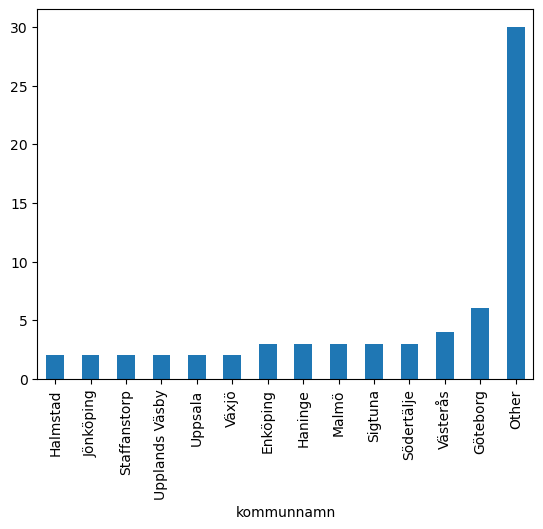

In [1107]:
mun_counts = filtered.groupby('kommunnamn')['block_id'].apply(lambda x : x.count() // 10)
mun_counts['Other'] = len(mun_counts[mun_counts == 1])
mun_counts = mun_counts[mun_counts > 1]
mun_counts.sort_values().plot.bar()

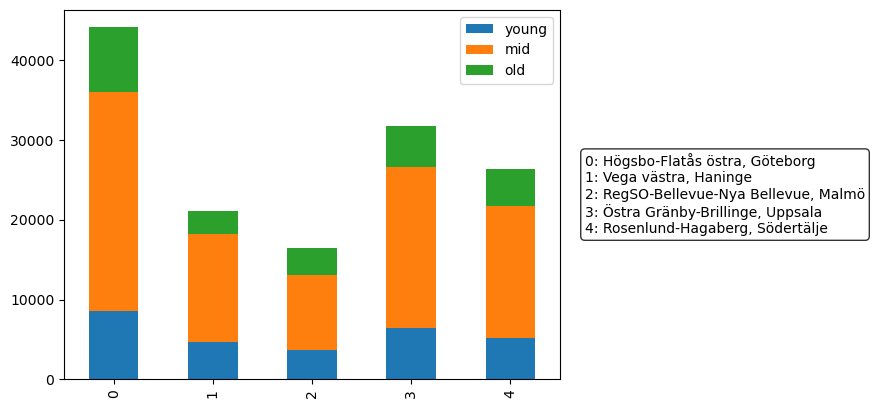

In [1186]:
filtered['interp'] = filtered['k'] * filtered['year'] + filtered['m']
filtered['plats'] = filtered['regsonamn'] + ', ' + filtered['kommunnamn']

curr = filtered.sort_values(['k', 'block_id', 'year'], ascending=False).groupby('block_id').apply('first')[['plats', 'k', 'young', 'mid', 'old']]#.plot.bar(stacked=True)
top = curr.nlargest(n=5, columns='k').reset_index()
ax = top[['young', 'mid', 'old']].plot.bar(stacked=True)

legend_labels = [f"{i}: {top.loc[i, 'plats']}" for i in range(len(top))]

mapping_text = "\n".join(legend_labels)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# Put the info box outside the plot
ax.text(1.05, 0.5, mapping_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='center', bbox=props)
plt.show()

/Users/johanslettengren/miniconda3/envs/curamando_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


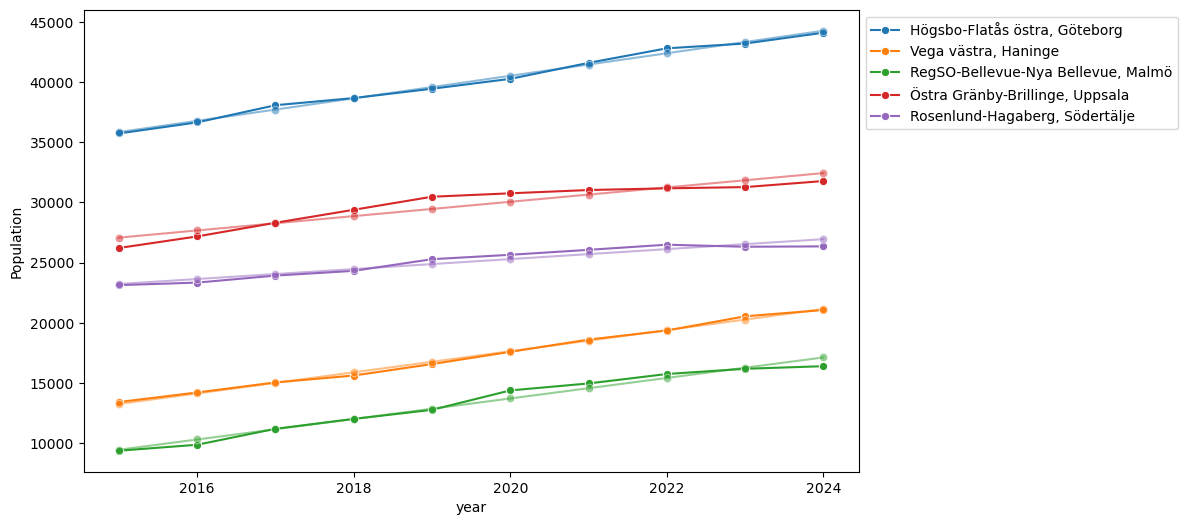

In [1225]:
filtered['interp'] = filtered['k'] * filtered['year'] + filtered['m']
filtered['plats'] = filtered['regsonamn'] + ', ' + filtered['kommunnamn']


ts = filtered.sort_values(by=['k', 'block_id', 'year'], ascending=False).iloc[:50][['block_id', 'plats', 'year', 'beftotalt', 'interp']]


plt.figure(figsize=(10,6))
sns.lineplot(data=ts, x='year', y='beftotalt', hue='plats', marker='o', units='block_id',estimator=None,)
sns.lineplot(data=ts, x='year', y='interp', hue='plats', marker='o', alpha=0.5, legend=False, units='block_id',estimator=None,)

# plt.title('Time Series by Group')
# plt.grid(True)
output_file = f'../output/forecast.png' 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel("Population")
plt.savefig(output_file, bbox_inches='tight', dpi=300) 


In [1040]:
# size of municipalilties in km^2
df.groupby(['regsonamn', 'year'])['beftotalt'].count().groupby('regsonamn').mean().describe()

count    3016.000000
mean       38.150531
std        68.585373
min         1.000000
25%         3.000000
50%         7.000000
75%        31.000000
max       592.000000
Name: beftotalt, dtype: float64

NaNs affect mainly areas that are (or were) not very densly populated. Hence, they shouldn't affect too much.

We impute missing values by filling (first forward then backward) in time.

In [1041]:
# size of regions in km^2
df.groupby(['kommunnamn', 'year'])['beftotalt'].count().groupby('kommunnamn').mean().describe()

count     290.000000
mean      396.765517
std       272.996382
min         8.000000
25%       212.250000
50%       341.500000
75%       515.000000
max      1729.000000
Name: beftotalt, dtype: float64

In [1042]:
df.groupby(['regsonamn', 'year'])['beftotalt'].count().groupby('regsonamn').mean().describe()

count    3016.000000
mean       38.150531
std        68.585373
min         1.000000
25%         3.000000
50%         7.000000
75%        31.000000
max       592.000000
Name: beftotalt, dtype: float64

In [1043]:
stats = df.copy()
stats['beftotalt'].describe(percentiles=[.5, .75, .9, .95])

count    1.150620e+06
mean     8.938373e+01
std      4.967233e+02
min      0.000000e+00
50%      9.000000e+00
75%      2.300000e+01
90%      7.700000e+01
95%      2.830000e+02
max      2.473700e+04
Name: beftotalt, dtype: float64

In [1044]:
from shapely import wkb

# Example binary geometry
geom_bytes = b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xb9(!\xa0v\xa8*@\xaajWz|\xaaK@A\nz\x0fE\xa8*@\xf2\xcd\x1f\xce\xa2\xabK@\xf5\xd1\xc2\xc1V\xb0*@\xf4\x1b\x03\xd6\xa9\xabK@\xfaS\xe6\xda\x87\xb0*@\x85>\xa1\x81\x83\xaaK@\xb9(!\xa0v\xa8*@\xaajWz|\xaaK@'

# Load geometry
geom = wkb.loads(geom_bytes)

# Geometry type
print("Geometry type:", geom.geom_type)

# Get coordinates
if geom.geom_type == 'Polygon':
    coords = list(geom.exterior.coords)
elif geom.geom_type == 'MultiPolygon':
    coords = [list(p.exterior.coords) for p in geom.geoms]

print(len(coords[0]))


Geometry type: MultiPolygon
5


In [1045]:
G = df.copy()
G['geometry'] = G['geometry'].apply(wkb.loads)

TypeError: Expected bytes or string, got MultiPolygon

In [ ]:
G

,rutid_inspire,beftotalt,kvinna,man,ald0_5,ald5_10,ald10_15,ald15_20,ald20_25,ald25_30,...,ald95_100,ald100w,year,regsokod,regsonamn,lanskod,kommunkod,kommunnamn,version,geometry
0,SE_CRS3006RES1000mN6133000E394000,5.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2015,1287R001,Alstad-Gislöv-Södra Åby-Södra Åby omland,12,1287,Trelleborg,2025_v1,MULTIPOLYGON (((13.329030040786494 55.33192376...
1,SE_CRS3006RES1000mN6133000E394000,5.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2016,1287R001,Alstad-Gislöv-Södra Åby-Södra Åby omland,12,1287,Trelleborg,2025_v1,MULTIPOLYGON (((13.329030040786494 55.33192376...
2,SE_CRS3006RES1000mN6133000E394000,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2017,1287R001,Alstad-Gislöv-Södra Åby-Södra Åby omland,12,1287,Trelleborg,2025_v1,MULTIPOLYGON (((13.329030040786494 55.33192376...
3,SE_CRS3006RES1000mN6133000E394000,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2018,1287R001,Alstad-Gislöv-Södra Åby-Södra Åby omland,12,1287,Trelleborg,2025_v1,MULTIPOLYGON (((13.329030040786494 55.33192376...
4,SE_CRS3006RES1000mN6133000E394000,6.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2019,1287R001,Alstad-Gislöv-Södra Åby-Södra Åby omland,12,1287,Trelleborg,2025_v1,MULTIPOLYGON (((13.329030040786494 55.33192376...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150615,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2020,2584R004,Kiruna nordost,25,2584,Kiruna,2025_v1,MULTIPOLYGON (((21.048921727806423 68.87138507...
1150616,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2021,2584R004,Kiruna nordost,25,2584,Kiruna,2025_v1,MULTIPOLYGON (((21.048921727806423 68.87138507...
1150617,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2022,2584R004,Kiruna nordost,25,2584,Kiruna,2025_v1,MULTIPOLYGON (((21.048921727806423 68.87138507...
1150618,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2023,2584R004,Kiruna nordost,25,2584,Kiruna,2025_v1,MULTIPOLYGON (((21.048921727806423 68.87138507...


In [ ]:

G['log_beftotalt'] = np.log1p(G['beftotalt'])
# # Create a GeoDataFrame
gdf = gpd.GeoDataFrame(G, geometry='geometry', crs="EPSG:4326")

# fig, ax = plt.subplots(figsize=(4,8))
# gdf.plot(column='log_beftotalt', cmap='YlOrRd', legend=True)
# ax.set_axis_off()
# ax.set_title("Population density (log scale)", fontsize=8)
# plt.show()
# plt.show()

In [ ]:

# Make sure CRS is in meters (not degrees)
gdf = gdf.to_crs(epsg=3857)  # or your local metric CRS

# Get centroid coordinates
gdf['x'] = gdf.centroid.x
gdf['y'] = gdf.centroid.y

block_size = 5000  # 5 km in meters

# Compute block IDs by integer division
gdf['block_x'] = (gdf['x'] // block_size).astype(int)
gdf['block_y'] = (gdf['y'] // block_size).astype(int)

# Create a combined block ID
gdf['block_id'] = gdf['block_x'].astype(str) + "_" + gdf['block_y'].astype(str)

In [ ]:
# Dissolve (aggregate) squares into 5 km² blocks
gdf_5km = gdf.dissolve(by=['block_id', 'year'], aggfunc='sum' )

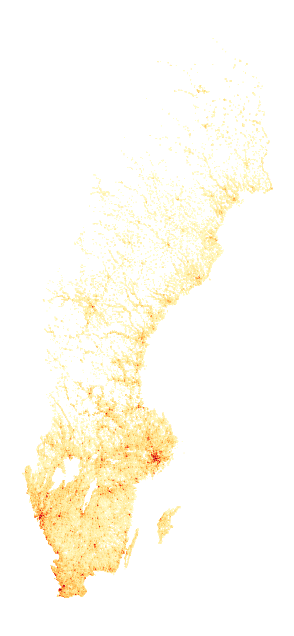

In [ ]:

G['log_beftotalt'] = np.log1p(G['beftotalt'])
# # Create a GeoDataFrame
#gdf = gpd.GeoDataFrame(G[['log_beftotalt', 'geometry']], geometry='geometry', crs="EPSG:4326").head(100000)

fig, ax = plt.subplots(figsize=(4,8))

#gdf_5km.plot(column='log_beftotalt', cmap='YlOrRd', ax=ax)
gdf_5km.plot(
    column='log_beftotalt',
    cmap='YlOrRd',
    ax=ax,

)
ax.set_axis_off()
plt.show()

In [ ]:
gdf_5km = gdf_5km.reset_index()

In [ ]:
gdf_5km['pct_change'] = gdf_5km.groupby('block_id')['beftotalt'].pct_change() * 100
gdf_5km['diff'] = gdf_5km['beftotalt'].diff()
gdf_5km['young'] = sum(gdf_5km[f'ald{y}_{y+5}'] for y in range(0, 20, 5))
gdf_5km['mid'] = sum(gdf_5km[f'ald{y}_{y+5}'] for y in range(20, 65, 5))
gdf_5km['old'] = sum(gdf_5km[f'ald{y}_{y+5}'] for y in range(65, 100, 5)) + gdf_5km[f'ald100w']

coeffs = gdf_5km.groupby('block_id')['year'].apply(lambda t: np.polyfit(t, gdf_5km.loc[t.index, 'beftotalt'], 1)).rename('coeffs')


gdf_5km = gdf_5km.merge(coeffs, on='block_id')

gdf_5km['k'] = gdf_5km['coeffs'].apply(lambda x : x[0])

In [ ]:
gdf_5km

,geometry,rutid_inspire,beftotalt,kvinna,man,ald0_5,ald5_10,ald10_15,ald15_20,ald20_25,...,y,block_x,block_y,pct_change,diff,young,mid,old,coeffs,k
block_id,,,,,,,,,,,,,,,,,,,,,
244_1631,"POLYGON ((1223312.4 8159105.185, 1225239.775 8...",SE_CRS3006RES1000mN6534000E269000,5.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,...,8.156267e+06,244,1631,NaN,NaN,0.0,0.0,3.0,"[0.0012406947890818852, 2.4999999999999996]",0.001241
245_1630,"POLYGON ((1225585.117 8153430.452, 1225470.073...",SE_CRS3006RES1000mN6533000E270000,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,8.154453e+06,245,1630,NaN,-2.0,0.0,0.0,0.0,"[0.0007444168734491311, 1.4999999999999998]",0.000744
245_1631,"POLYGON ((1225354.959 8157290.236, 1225239.775...",SE_CRS3006RES1000mN6534000E270000,50.0,20.0,29.0,5.0,3.0,4.0,0.0,3.0,...,8.156383e+06,245,1631,NaN,47.0,12.0,31.0,18.0,"[0.01240694789081885, 24.999999999999993]",0.012407
245_1632,"POLYGON ((1227167.22 8159336.039, 1225239.775 ...",SE_CRS3006RES1000mN6536000E270000,8.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,8.160244e+06,245,1632,NaN,-42.0,0.0,0.0,0.0,"[0.0019851116625310165, 3.9999999999999996]",0.001985
246_1628,"POLYGON ((1233966.301 8142318.203, 1232043.102...",SE_CRS3006RES1000mN6527000E273000,8.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,8.143225e+06,246,1628,NaN,0.0,0.0,7.0,0.0,"[0.0019851116625310165, 3.9999999999999996]",0.001985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536_1971,"POLYGON ((2680022.078 9855314.372, 2680374.322...",SE_CRS3006RES1000mN7341000E912000,41.0,22.0,18.0,3.0,0.0,6.0,7.0,0.0,...,9.856347e+06,536,1971,NaN,26.0,16.0,30.0,3.0,"[0.010173697270471458, 20.499999999999996]",0.010174
537_1965,"MULTIPOLYGON (((2685785.395 9827368.844, 26861...",SE_CRS3006RES1000mN7329000E917000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.825635e+06,537,1965,NaN,-38.0,0.0,3.0,0.0,"[0.0007444168734491311, 1.4999999999999998]",0.000744
537_1966,"POLYGON ((2684084.436 9832537.976, 2684436.705...",SE_CRS3006RES1000mN7331000E915000,1173.0,580.0,592.0,82.0,73.0,60.0,63.0,85.0,...,9.831157e+06,537,1966,NaN,1170.0,278.0,682.0,209.0,"[0.29106699751861026, 586.4999999999999]",0.291067


In [ ]:
stats['k'] = stats['coeffs'].apply(lambda x : x[0])

,rutid_inspire,beftotalt,kvinna,man,ald0_5,ald5_10,ald10_15,ald15_20,ald20_25,ald25_30,...,kommunnamn,version,geometry,pct_change,diff,young,mid,old,coeffs,k
0,SE_CRS3006RES1000mN6133000E394000,5.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Trelleborg,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,NaN,NaN,0.0,8.0,0.0,"[0.2666666666666823, -532.333333333365]",0.266667
1,SE_CRS3006RES1000mN6133000E394000,5.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Trelleborg,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,0.0,0.0,0.0,5.0,3.0,"[0.2666666666666823, -532.333333333365]",0.266667
2,SE_CRS3006RES1000mN6133000E394000,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Trelleborg,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,20.0,1.0,0.0,0.0,3.0,"[0.2666666666666823, -532.333333333365]",0.266667
3,SE_CRS3006RES1000mN6133000E394000,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Trelleborg,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,0.0,0.0,0.0,3.0,3.0,"[0.2666666666666823, -532.333333333365]",0.266667
4,SE_CRS3006RES1000mN6133000E394000,6.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Trelleborg,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,0.0,0.0,0.0,6.0,3.0,"[0.2666666666666823, -532.333333333365]",0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150615,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Kiruna,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,NaN,0.0,0.0,0.0,0.0,"[0.0, 0.0]",0.000000
1150616,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Kiruna,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,NaN,0.0,0.0,0.0,0.0,"[0.0, 0.0]",0.000000
1150617,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Kiruna,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,NaN,0.0,0.0,0.0,0.0,"[0.0, 0.0]",0.000000
1150618,SE_CRS3006RES1000mN7652000E743000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Kiruna,2025_v1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,NaN,0.0,0.0,0.0,0.0,"[0.0, 0.0]",0.000000


In [ ]:
stats['growing'] = stats['k'] > 0

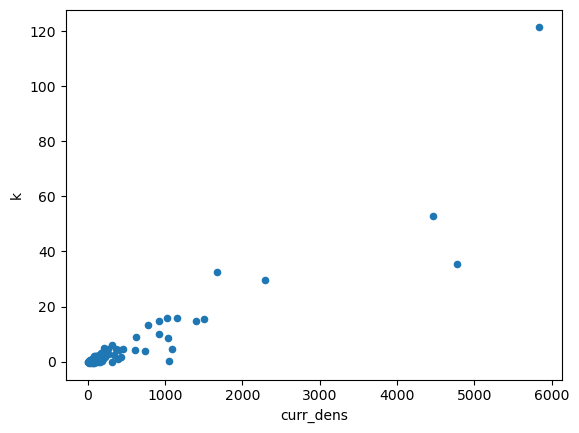

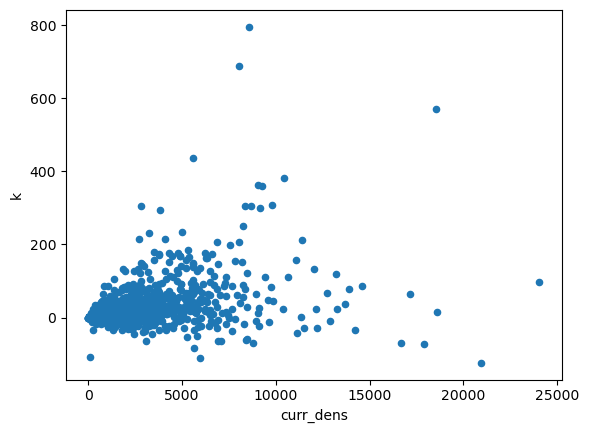

In [ ]:
agg_dict = {
    'rutid_inspire': 'count',  # this becomes "area"
    'beftotalt': 'sum',        # total
}


agg_dict = {
    'area': ('rutid_inspire', 'count'),
}

# Add all DATA_COLS as sums
agg_dict.update({col: (col, 'sum') for col in DATACOLS})


def aggregate_reg(df, regname='kommunnamn'):
    
    stats = (
    df.groupby([regname, 'year'])
      .agg(**agg_dict)  # now each output column = (input column, function)
      .reset_index()
      .sort_values(by=[regname, 'year'])
    )



    for c in DATACOLS:
        stats[f'{c}_dens'] = stats[c] / stats['area']
        
    stats['pct_change'] = stats['beftotalt_dens'].pct_change() * 100
    stats['dens_change'] = stats['beftotalt_dens'].diff()
    stats['young_dens'] = sum(stats[f'ald{y}_{y+5}_dens'] for y in range(0, 20, 5))
    stats['mid_dens'] = sum(stats[f'ald{y}_{y+5}_dens'] for y in range(20, 65, 5))
    stats['old_dens'] = sum(stats[f'ald{y}_{y+5}_dens'] for y in range(65, 100, 5)) + stats[f'ald100w']
    
    agg_stats = (
        stats.groupby(regname)
        .agg(
            curr_dens = ('beftotalt_dens', 'last'),
            ew_pct_change = ('pct_change', lambda x: x.ewm(alpha=0.9).mean().iloc[-1]),
            ew_dens_change = ('dens_change', lambda x: x.ewm(alpha=0.9).mean().iloc[-1]),
            k=('year', lambda t: np.polyfit(t, stats.loc[t.index, 'beftotalt_dens'], 1)[0]),
            m=('year', lambda t: np.polyfit(t, stats.loc[t.index, 'beftotalt_dens'], 1)[1])
        )
        .reset_index()
    )
    ax = agg_stats.plot.scatter(x='curr_dens', y='k')
    #agg_stats[['curr_dens','k', regname ]].apply(lambda row: ax.text(*row),axis=1);
    
    plt.show()

    stats = stats.merge(agg_stats, on=regname)

    stats['interp'] = stats['year'] * stats['k'] + stats['m']

    return stats

mun_stats = aggregate_reg(df)
reg_stats = aggregate_reg(df, 'regsonamn')


In [ ]:
reg_stats

,regsonamn,year,area,beftotalt,kvinna,man,ald0_5,ald5_10,ald10_15,ald15_20,...,dens_change,young_dens,mid_dens,old_dens,curr_dens,ew_pct_change,ew_dens_change,k,m,interp
0,Abrahamsberg,2015,1,5037.0,2578.0,2460.0,298.0,311.0,311.0,247.0,...,NaN,1167.0,3217.0,642.0,4950.0,-1.207311,-60.602782,-7.078788,19298.212121,5034.454545
1,Abrahamsberg,2016,1,5061.0,2569.0,2488.0,309.0,293.0,317.0,258.0,...,24.0,1177.0,3224.0,665.0,4950.0,-1.207311,-60.602782,-7.078788,19298.212121,5027.375758
2,Abrahamsberg,2017,1,4987.0,2543.0,2449.0,284.0,316.0,305.0,276.0,...,-74.0,1181.0,3149.0,664.0,4950.0,-1.207311,-60.602782,-7.078788,19298.212121,5020.296970
3,Abrahamsberg,2018,1,5010.0,2573.0,2438.0,262.0,319.0,293.0,301.0,...,23.0,1175.0,3160.0,675.0,4950.0,-1.207311,-60.602782,-7.078788,19298.212121,5013.218182
4,Abrahamsberg,2019,1,5016.0,2589.0,2430.0,243.0,308.0,308.0,317.0,...,6.0,1176.0,3144.0,700.0,4950.0,-1.207311,-60.602782,-7.078788,19298.212121,5006.139394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30155,Öxnehaga,2020,2,2364.0,1169.0,1196.0,146.0,189.0,190.0,163.0,...,-12.0,344.0,605.0,230.5,1373.0,3.563154,45.923838,35.257576,-70020.424242,1199.878788
30156,Öxnehaga,2021,2,2379.0,1175.0,1204.0,154.0,191.0,189.0,165.0,...,7.5,349.5,608.5,231.0,1373.0,3.563154,45.923838,35.257576,-70020.424242,1235.136364
30157,Öxnehaga,2022,2,2373.0,1161.0,1212.0,133.0,201.0,187.0,181.0,...,-3.0,351.0,605.5,229.0,1373.0,3.563154,45.923838,35.257576,-70020.424242,1270.393939
30158,Öxnehaga,2023,2,2674.0,1331.0,1340.0,138.0,209.0,190.0,197.0,...,150.5,367.0,735.0,242.0,1373.0,3.563154,45.923838,35.257576,-70020.424242,1305.651515


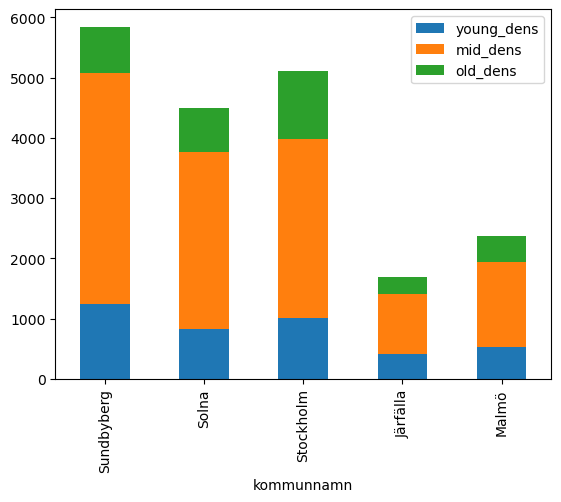

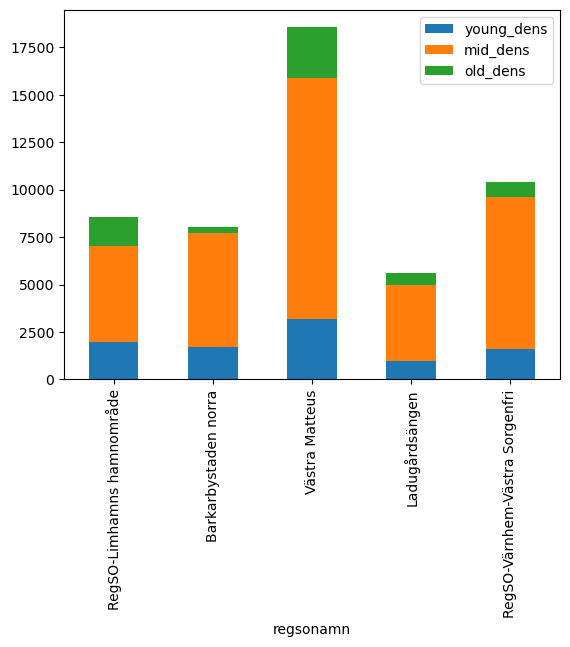

In [ ]:
mun_stats = mun_stats.sort_values(by=['ew_dens_change', 'year'], ascending=[False, False])

def stacked_bar(stats, regname='kommunnamn', by='ew_dens_change', top_K=10):
    curr = stats.sort_values(by='year').groupby(regname).agg('last').sort_values(by=[by], ascending=False).iloc[:top_K]
    curr[['young_dens', 'mid_dens', 'old_dens']].plot.bar(stacked=True)
    plt.show()
    
stacked_bar(mun_stats, regname='kommunnamn', by='k', top_K=5)
stacked_bar(reg_stats, regname='regsonamn', by='k', top_K=5)

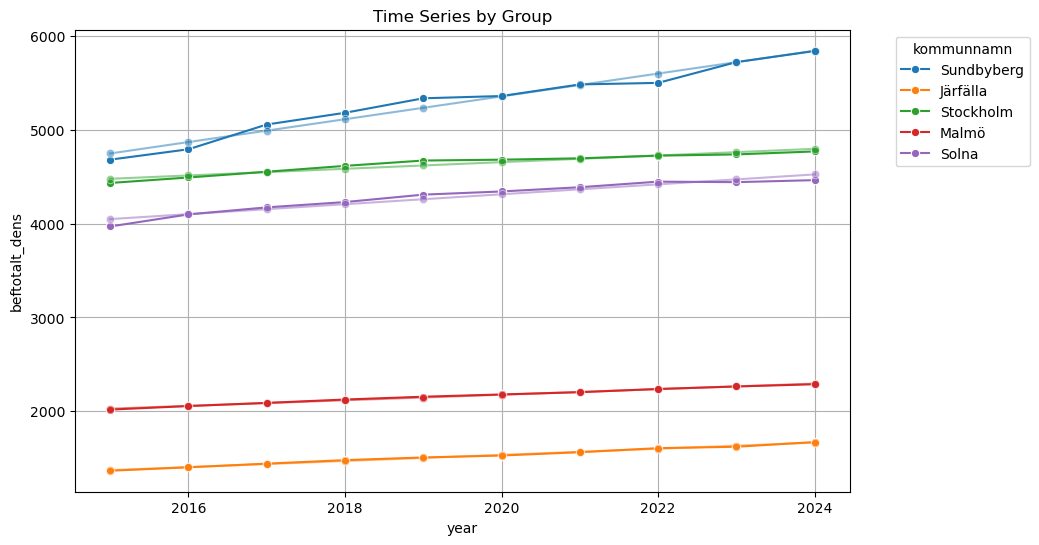

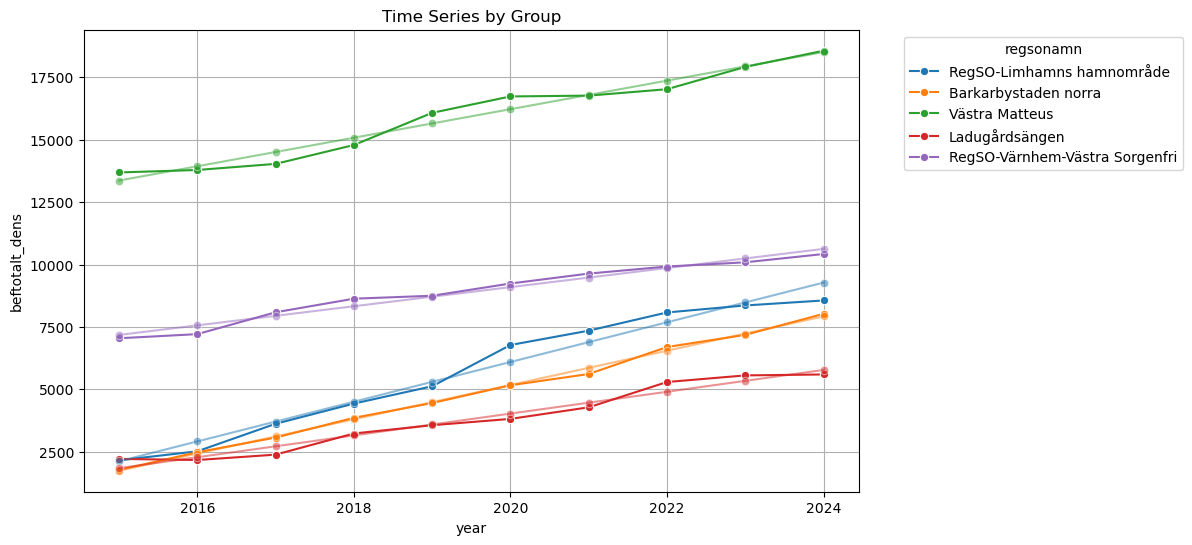

In [ ]:

def plot_timeseries(stats,regname='kommunnamn', by='ew_dens_change', top_K=10):
    import seaborn as sns

    ts = stats.sort_values(by=[by, regname, 'year'], ascending=False).iloc[:10*top_K][[regname, 'year', 'beftotalt_dens', 'interp']]
    plt.figure(figsize=(10,6))
    sns.lineplot(data=ts, x='year', y='beftotalt_dens', hue=regname, marker='o')
    sns.lineplot(data=ts, x='year', y='interp', hue=regname, marker='o', alpha=0.5, legend=False)

    plt.title('Time Series by Group')
    plt.grid(True)
    plt.legend(title=regname, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    
plot_timeseries(mun_stats, regname='kommunnamn', by='ew_dens_change', top_K=5)
plot_timeseries(reg_stats, regname='regsonamn', by='k', top_K=5)
